In [ ]:
## from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import cv2
import os
from pathlib import Path

In [0]:
class Preprocessor:
    def __init__(self, width, height, interpolAlgo=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.intterpolAlgo = interpolAlgo

    def process(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.intterpolAlgo)

In [0]:



class Dataloader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, pathToFolder, verbose=False):
        data = []
        labels = []

        folder = Path(pathToFolder)

        for classFolder in folder.iterdir():
            if not classFolder.is_dir():
                raise ValueError(
                    "Data Loader Error: Inappropriate folder structure. File found at first level")

            # os.path.split splits the path into head and tail, tail being just the folder name.
            label = os.path.split(classFolder)[1]
            for datapoint in classFolder.iterdir():
                if datapoint.is_dir():
                    raise ValueError(
                        "Data Loader Error: Inapprpriate folder structure. Folder found at second level")

                image = cv2.imread(str(datapoint))

                if image is None:
                    raise ValueError(str(datapoint) + " is corrupted")
                for preprocessor in self.preprocessors:
                    image = preprocessor.process(image)

                if verbose:
                    print("[INFO] Loading image: " + str(datapoint))
                data.append(image)
                labels.append(label)

        return (np.array(data), np.array(labels))




In [5]:
from keras.preprocessing.image import img_to_array


class ImageToArrayPreprocessor:
    def __init__(self, dataFormat = None):
        self.dataFormat = dataFormat

    def process(self, image):
        return img_to_array(image, data_format=self.dataFormat)

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd "drive/My Drive"

/content/drive/My Drive


In [0]:
sp = Preprocessor(24,24)
iap = ImageToArrayPreprocessor()
sdl = Dataloader(preprocessors=[sp, iap])

In [11]:
%%time
(data, labels) =  sdl.load("eyes")

CPU times: user 2.09 s, sys: 2.05 s, total: 4.14 s
Wall time: 18.1 s


In [0]:
labels = labels.reshape(labels.shape[0], 1)

In [13]:
print(data.shape)
print(labels.shape)

(4846, 24, 24, 3)
(4846, 1)


In [0]:
data = data / 255.0

In [15]:
print(data[0][0][0])

[0.22352941 0.22352941 0.22352941]


In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as keras_backend
from keras.optimizers import SGD

In [0]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        
        if keras_backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        
        model.add(Conv2D(32, (3,3), padding="same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation("sigmoid"))
        
        return model

In [0]:
class NoNet:
    @staticmethod
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        
        if keras_backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        model = Sequential([
            Conv2D(32, kernel_size=(3, 3), activation='relu',
                   input_shape= inputShape),
            MaxPooling2D(pool_size=(1, 1)),
            # 32 convolution filters used each of size 3x3
            # again
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(1, 1)),

            # 64 convolution filters used each of size 3x3
            # choose the best features via pooling

            # randomly turn neurons on and off to improve convergence
            Dropout(0.5),
            # flatten since too many dimensions, we only want a classification output
            Flatten(),
            # fully connected to get all relevant data
            Dense(128, activation='relu'),
            # one more dropout for convergence' sake :)
            Dropout(0.5),
            # output a softmax to squash the matrix into output probabilities
            Dense(classes, activation='sigmoid')
        ])

        return model

In [0]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size = 0.25, random_state=42)

In [0]:
opt = SGD(lr=0.005)
model = NoNet.build(24,24, 3, 1)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [23]:
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

Train on 3634 samples, validate on 1212 samples
Epoch 1/100
3634/3634 [==============================] - 7s 2ms/step - loss: 0.6836 - accuracy: 0.5405 - val_loss: 0.6581 - val_accuracy: 0.6683
Epoch 2/100
3634/3634 [==============================] - 1s 184us/step - loss: 0.6503 - accuracy: 0.6346 - val_loss: 0.6134 - val_accuracy: 0.6782
Epoch 3/100
3634/3634 [==============================] - 1s 186us/step - loss: 0.6144 - accuracy: 0.6767 - val_loss: 0.5611 - val_accuracy: 0.7731
Epoch 4/100
3634/3634 [==============================] - 1s 188us/step - loss: 0.5719 - accuracy: 0.7221 - val_loss: 0.5188 - val_accuracy: 0.7805
Epoch 5/100
3634/3634 [==============================] - 1s 187us/step - loss: 0.5395 - accuracy: 0.7345 - val_loss: 0.4910 - val_accuracy: 0.7789
Epoch 6/100
3634/3634 [==============================] - 1s 199us/step - loss: 0.5068 - accuracy: 0.7565 - val_loss: 0.4611 - val_accuracy: 0.7970
Epoch 7/100
3634/3634 [==============================] - 1s 221us/step -

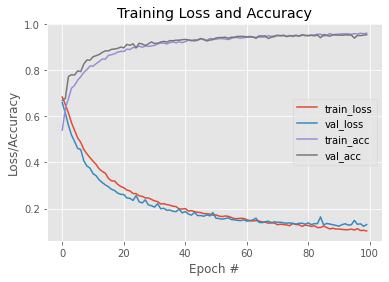

In [24]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [0]:
model.save("dddshallow.hdf5")